# Backup: original GP with single hexapole as tunable parameter

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated')
saveResultsQ = False
import scipy

### Creat the machine interface

In [72]:
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[4.99]]  # use H1 = H2 = 25 as default start, following Cameron's setup
#min-max range

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
# assuming an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background 
# noise with std dev = 0.1

In [73]:
mi.x[0]

array([4.99])

In [74]:
#check the reading objective is working
mi.getState()

(array([[4.99]]), array([[-1086312.46603691]]))

In [67]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

0.0

### Create the gp

In [75]:
gp_ls = np.array(np.ones(ndim))
gp_amp = 3e6 # default = 1
gp_noise = 0.0  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

/nfs/user/cz489/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### Create the BO

In [76]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f581674efd0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[4.99]]
y_init [[-1086312.46603691]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [77]:
Obj_state_s=[]

iteration = 0
current position: [[4.99]] current objective value: [-1086312.46603691]


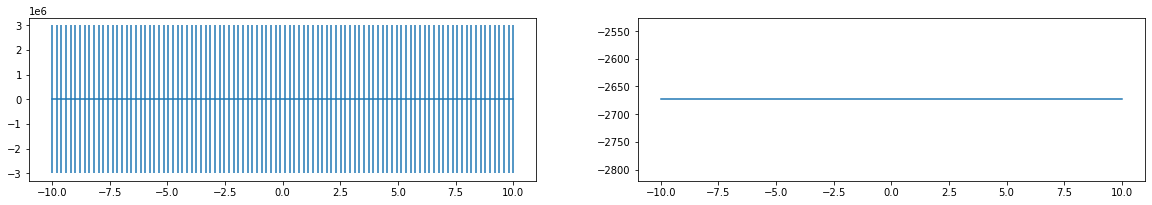

[4.99] [[-1086312.46603691]]
[4.99]
single-processing, minimize, x_start = [4.99]
Minimizing finished, min point = [4.989]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[4.989]], [[-1080947.55356074]]
iteration = 1
current position: [[4.989]] current objective value: [-1086312.46603691]


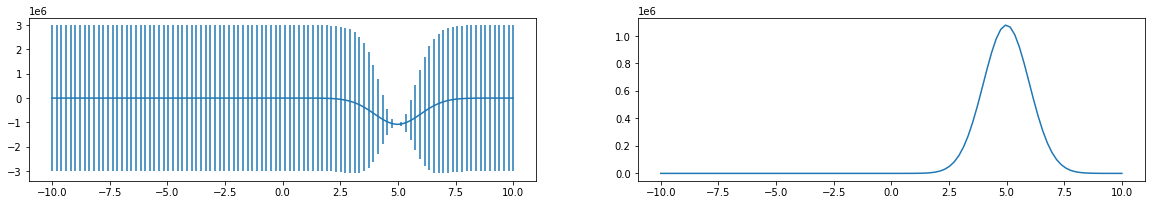

[4.989] [[-1080947.55356074]]
[4.989]
single-processing, minimize, x_start = [4.989]
Minimizing finished, min point = [-10.]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[-10.]], [[-4649790.63791582]]
iteration = 2
current position: [[-10.]] current objective value: [-1086312.46603691]


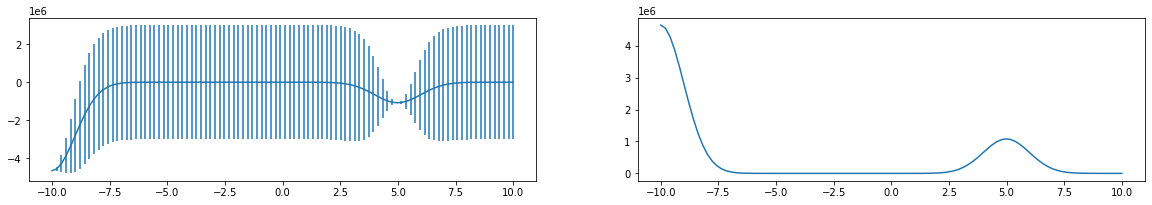

[4.989] [[-1080947.55356074]]
[4.989]
single-processing, minimize, x_start = [4.989]
Minimizing finished, min point = [-2.52960904]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[-2.52960904]], [[-489372.22024348]]
iteration = 3
current position: [[-2.52960904]] current objective value: [-1086312.46603691]


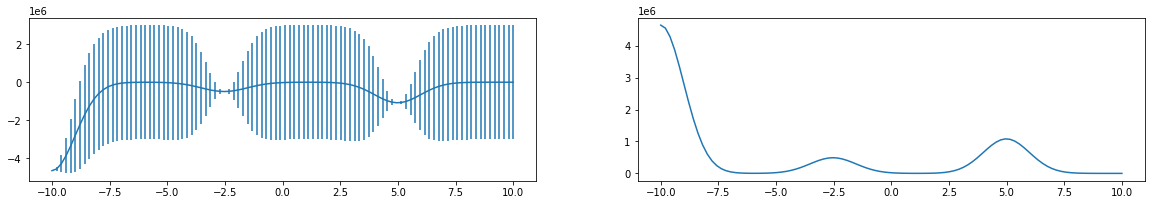

[-2.52960904] [[-489372.22024348]]
[-2.52960904]
single-processing, minimize, x_start = [-2.52960904]
Minimizing finished, min point = [-5.94008959]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[-5.94008959]], [[-1716429.13044642]]
iteration = 4
current position: [[-5.94008959]] current objective value: [-1086312.46603691]


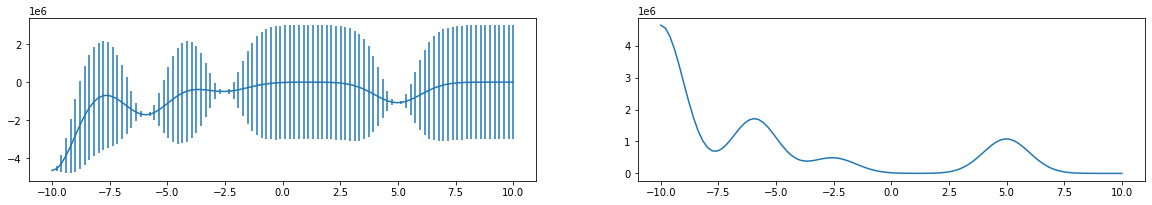

[-2.52960904] [[-489372.22024348]]
[-2.52960904]
single-processing, minimize, x_start = [-2.52960904]
Minimizing finished, min point = [10.]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[10.]], [[-4574646.62144507]]
iteration = 5
current position: [[10.]] current objective value: [-1086312.46603691]


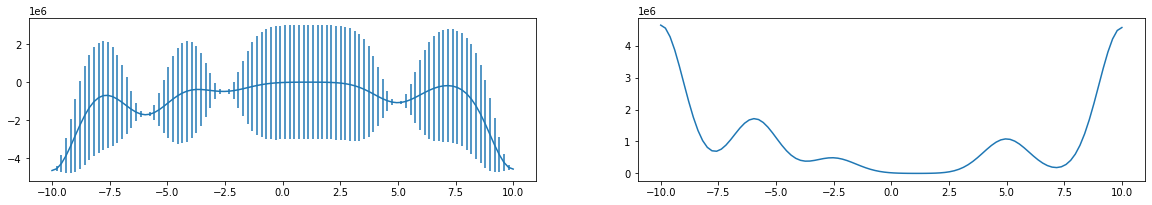

[-2.52960904] [[-489372.22024348]]
[-2.52960904]
single-processing, minimize, x_start = [-2.52960904]
Minimizing finished, min point = [1.11477255]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[1.11477255]], [[-167601.35739054]]
iteration = 6
current position: [[1.11477255]] current objective value: [-1086312.46603691]


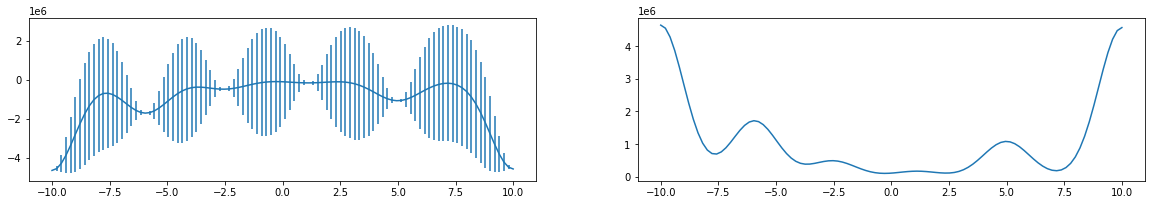

[1.11477255] [[-167601.35739054]]
[1.11477255]
single-processing, minimize, x_start = [1.11477255]
Minimizing finished, min point = [-0.28788223]
New State: [[-0.28788223]], [[-79633.65416252]]
iteration = 7
current position: [[-0.28788223]] current objective value: [-1086312.46603691]


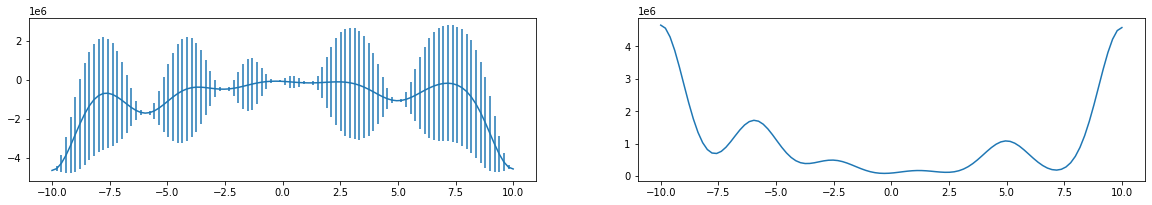

[-0.28788223] [[-79633.65416252]]
[-0.28788223]
single-processing, minimize, x_start = [-0.28788223]
Minimizing finished, min point = [-0.31493644]
New State: [[-0.31493644]], [[-80391.50263048]]


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [78]:
Niter = 8
for i in range(Niter):
    
    print ('iteration =', i)
   
    Obj_state_s.append(mi.getState()[1][0])
    print ('current position:', mi.x, 'current objective value:', Obj_state_s[-0])
    
    f = plt.figure(figsize=(20,3))
#     ax = f.add_subplot(121)
#     ax2 = f.add_subplot(122)
#     ax.set_ylabel('Input controls',fontsize=12)
#     ax.set_xlabel('Step',fontsize=12)    
#     ax.plot(opt.X_obs)
#     ax2.set_ylabel('Objective',fontsize=12)
#     ax2.set_xlabel('Step',fontsize=12)
#     ax2.plot(Obj_state_s)
#     plt.show(); 
    
    x = np.linspace(-10,10,100)
    y = x*0
    yval = x*0
    yerr = x*0
    for i in range(len(x)):
        y[i] = negUCB(x[i],opt.model, 1, 0)
        yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
        yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
    plt.subplot(121)
    plt.errorbar(x,yval,yerr = yerr)

    plt.subplot(122)
    plt.plot(x,y)
    plt.show()
    
#     clear_output(wait=True) 
    
    opt.OptIter()

## Test behavior of the negative UCB function and scipy.optimize.minimize

In [61]:
print('negUCB = ' + str(negUCB(4.0, opt.model, 1, 0)))
print(opt.model.predict(np.array([5.000],ndmin=2)))

negUCB = 661105.5947475976
(array([[-1080883.0724912]]), array([[241.9853595]]))


/home/cz489/STEMalign_BO/modules/bayes_optimization.py:508: RuntimeWarning: invalid value encountered in sqrt
  GPUCB = y_mean + np.sqrt(nu * tau * y_var)


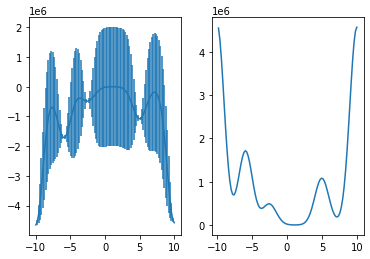

In [62]:
x = np.linspace(-10,10,100)
y = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y[i] = negUCB(x[i],opt.model, 1, 0)
    yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
plt.subplot(121)
plt.errorbar(x,yval,yerr = yerr)

plt.subplot(122)
plt.plot(x,y)

In [17]:
opt.model.predict(np.array([4.9],ndmin=2))

(array([[-1110698.93832676]]), array([[19506.25345827]]))

In [17]:
negUCB(x0, opt.model, ndim, nsteps, nu, delta)

NameError: name 'x0' is not defined

In [20]:
bnds = [(-10, 10)]
x0 = 5
ndim = 1
nsteps = 1
nu = 2
delta = None
res = scipy.optimize.minimize(negUCB, x0, args=(opt.model, ndim, nsteps, nu, delta), 
                              method='L-BFGS-B',tol=1e-4,bounds=bnds,options={'maxiter':1000})     
print(res.x)

[10.]


In [18]:
#save results if desired
from datetime import datetime
import time
def saveResults(filename):
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results/multinormal')
    except: pass
    results = {}
    results['start_point'] = start_point
    results['hyps'] = [gp_precisionmat,gp_amp, gp_noise]
    results['offset'] = offset
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/multinormal/scan_'+timestr+'_'+filename, results)
    print('saved to:  saved_results/GPT/  scan_'+timestr+'_'+filename)

In [21]:
saveResults('exmple1')

NameError: name 'offset' is not defined

## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.

In [6]:
# 1D scan along hex1 = hex2
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-6,6,num=50)
emit_list = []

for i in range(len(hex_list)):
    start_point = [hex_list[i],0] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_list.append(mi.getState()[1][0])
    print(hex_list[i], emit_list[-1])

-6.0 [1777728.16712034]
-5.755102040816326 [1489545.1659417]
-5.510204081632653 [1236426.3376191]
-5.26530612244898 [1103062.0703468]
-5.020408163265306 [1149374.89826194]
-4.775510204081632 [1109441.36124244]
-4.530612244897959 [1061567.44878181]
-4.285714285714286 [958077.11662882]
-4.040816326530612 [836045.03188367]
-3.795918367346939 [760155.32448412]
-3.5510204081632653 [736298.78843037]
-3.306122448979592 [629282.39037404]
-3.0612244897959187 [575331.43676784]
-2.816326530612245 [543411.93463123]
-2.5714285714285716 [497426.23902252]
-2.326530612244898 [460014.43255871]
-2.0816326530612246 [382618.22309398]
-1.8367346938775508 [326577.75740373]
-1.591836734693878 [264797.32465318]
-1.3469387755102042 [210430.59791467]
-1.1020408163265305 [164351.05050827]
-0.8571428571428577 [129019.33306826]
-0.6122448979591839 [102231.42192757]
-0.36734693877551017 [84584.75968091]
-0.12244897959183731 [75737.58170651]
0.12244897959183643 [77353.23010822]
0.36734693877551017 [84685.30723048]
0

(array([-250000.,       0.,  250000.,  500000.,  750000., 1000000.,
        1250000., 1500000., 1750000., 2000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

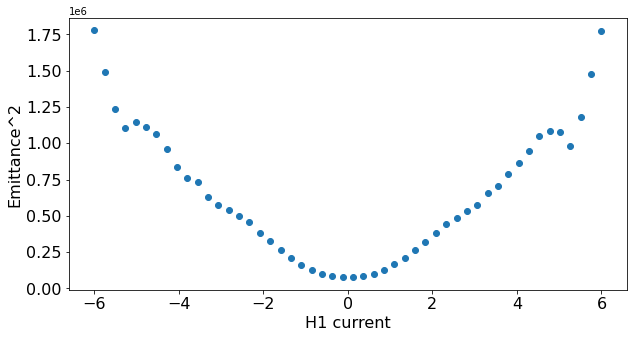

In [7]:
# hex_list = np.load('hex_list_h2=-100_100_h2=8.npy')
# emit_list = np.load('emit_list_h2=-100_100_h2=8.npy')

fig = plt.figure(figsize = [10,5])
plt.scatter(hex_list, np.asarray(emit_list))
plt.ylabel('Emittance^2',fontsize = 16)
plt.xlabel('H1 current',fontsize  = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('hex_scan_h1=-100_100_h2=8.png')

# np.save('emit_list_h2=-100_100_h1=50.npy',np.asarray(emit_list))
# np.save('hex_list_h2=-100_100_h1=50.npy',hex_list)

44.0 -100.0 12059988.672165059


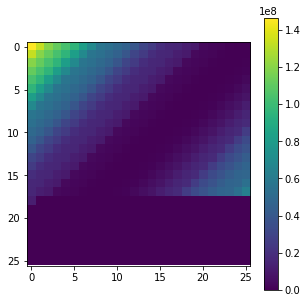

In [ ]:
# 2D parameter scan for all (hex1, hex2) pairs
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-100,100,num=26)
emit_matrix = np.zeros([26,26])

for i in range(len(hex_list)):
    for j in range(len(hex_list)):
        imgname = '/home/cz489/STEMalign_BO/SimulationResults/ronchigram_'+ str(i)+'_'+str(j)+'.npy'
        txtname = '/home/cz489/STEMalign_BO/SimulationResults/outscope_'+ str(i)+'_'+str(j)+'.txt'
        if os.path.exists(txtname):
            emit_matrix[i,j] = calcEmittance(txtname)
        else:
            start_point = [hex_list[i],hex_list[j]]  # use H1 = H2 = 25 as default start, following Cameron's setup
            mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
            mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
            emit_matrix[i,j] = mi.getState()[1][0]
            
#             os.rename("/home/cz489/STEMalign_BO/outscope.txt", txtname)
#             os.rename("/home/cz489/STEMalign_BO/ronchigram.npy", imgname)
        
        clear_output(wait=True)
        print(hex_list[i], hex_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix)
        plt.colorbar()
        plt.show()


            

In [3]:
start_point = [36,-44]  # use H1 = H2 = 25 as default start, following Cameron's setup
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
print(mi.getState())

(array([[ 36, -44]]), array([[3297512.23044574]]))


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
def calcEmittance(ASCIIFILE):
    screen =  np.loadtxt(ASCIIFILE, skiprows=5)
    N = 24
    maxsig = 1
    MConHBAR  =  2.59e12
    x_grid, y_grid = np.meshgrid(np.linspace(-N/2, N/2, N),
                             np.linspace(-N/2, N/2, N))
    temp = x_grid * x_grid + y_grid * y_grid
    mask =temp < N*N/4

    x  = screen[:,0]
    y  = screen[:,1]
    kx = MConHBAR*screen[:,4]*screen[:,7]
    ky = MConHBAR*screen[:,5]*screen[:,7]

    meanx = np.mean(x)
    sigx  = np.std(x)

    meany = np.mean(y)
    sigy  = np.std(y)

    kx_bins = [[[] for n in range(0,N)] for m in range(0,N)]
    ky_bins = [[[] for n in range(0,N)] for m in range(0,N)]

    kx_grid = np.zeros([N, N])
    ky_grid = np.zeros([N, N])

    x_grid, y_grid = np.meshgrid(sigx*np.linspace(-maxsig, maxsig, N),
                                 sigy*np.linspace(-maxsig, maxsig, N))

    for xi, yi, kxi, kyi in zip(x, y, kx, ky):
        i = int(0.5*N*((yi-meany)/(maxsig*sigy)) + 0.5*N)
        j = int(0.5*N*((xi-meanx)/(maxsig*sigx)) + 0.5*N)
        if i < 0 or i > N-1 or j < 0 or j > N-1:
            continue
        kx_bins[i][j].append(kxi)
        ky_bins[i][j].append(kyi)

    for i in range(0, N):
        for j in range(0, N):
            kx_grid[i,j] = np.mean(kx_bins[i][j])
            ky_grid[i,j] = np.mean(ky_bins[i][j])

    a, b = np.polyfit(x_grid[12,:], kx_grid[12,:], 1)
    kx_grid = kx_grid - a * x_grid
    ky_grid = ky_grid - a * y_grid
    emit_1 = np.power(kx_grid, 2) + np.power(ky_grid, 2)  # first term, absolute value of gradient of aberration function
    emit_2 = np.power(x_grid, 2) + np.power(y_grid, 2)
    emit_3 = kx_grid * x_grid + ky_grid * y_grid  # third term, cross term between x/y and gradient along x/y
    emit = emit_1 * emit_2 - emit_3
    emit[np.isnan(emit)] = 0
    objective_state = np.sum(emit * mask)
    return objective_state

In [34]:
def negUCB(x_new, model, ndim, nsteps, nu = 1., delta = 1.):
    """
    GPUCB: Gaussian process upper confidence bound aquisition function
    Default nu and delta hyperparameters theoretically yield "least regret".
    Works better than "expected improvement" (for alpha==1 above) in 2D.

    input params
    x_new: new point in the dim-dimensional space the GP is fitting
    model: OnlineGP object
    ndim: feature space dimensionality (how many devices are varied)
    nsteps: current step number counting from 1
    nu: nu in the tutorial (see above)
    delta: delta in the tutorial (see above)
    """

    if nsteps==0: nsteps += 1
    (y_mean, y_var) = model.predict(np.array(x_new,ndmin=2))

    if delta is None:
        GPUCB = y_mean + nu * np.sqrt(y_var)
    else:
        tau = 2.*np.log(nsteps**(0.5*ndim+2.)*(np.pi**2.)/3./delta)
        GPUCB = y_mean + np.sqrt(nu * tau * y_var)
    GPUCB = np.squeeze(GPUCB)

    return -GPUCB